<a href="https://colab.research.google.com/github/visheshgupta19/Interpretable-ML/blob/main/XAI_Interpretable_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from pygam import LogisticGAM, s, f, te

In [399]:
# read the csv kaggle dataset
data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Data Cleaning

- We initially explore our data set and all the column types. This allows us to convert those column types if needed to our desired one. This also helps us understand and see if our data types are correct so we can compute statistics and train models In our case we have gone ahead and converted TotalCharges from object → numeric.

- We are able to drop any columns that we believe will not help us in the analysis. In our case we dropped the customerID column as IDs do not help prediction and can create data leakage or wasted memory.

- We then check for any missing values and how many are there so that we can analyse them and see if they are random or have a pattern and should we be removing them or not

In [400]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [401]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [402]:
data.shape

(7043, 21)

In [403]:
# convert TotalCharges to numeric type
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [404]:
# check for duplicates
data.duplicated().sum()

np.int64(0)

In [405]:
# check if there is any missing values
print(data.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [406]:
data[data['TotalCharges'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- From the above analysis we notice that when we converted TotalCharges from being stored as an object(string) to a numeric value enteries that were porobably blank would have been assigned as NaN.  

- On analysis of these 11 rows it is evident that they correspond to customers with tenure = 0 which would indicate that these are brand new customers who have not paid yet.

- Since they haven't paid anything we could go ahead set total charges to 0 as logically if tenure is 0 then total charges should also be 0

In [407]:
# setting NaN to 0 for TotalCharges
data['TotalCharges'] = data['TotalCharges'].fillna(0)

# sanity check
print(data['TotalCharges'].isnull().sum())

0


In [408]:
# drop customer ID
data = data.drop(columns=['customerID'])

Analysing the target variable (Churn)

- We now would like to check to see if there any any imbalances in our target varibale i.e. churn as this would impact our approach towards evaluation metrics and modeling approaches. If we do have an imablance then we would want to consider setting class weights or following some other approach to balance the data.

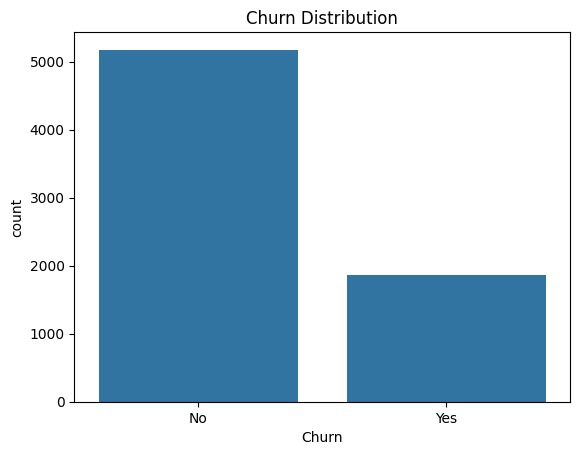

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [409]:
# check for any imabalance
sns.countplot(data=data, x='Churn')
plt.title("Churn Distribution")
plt.show()

print(data['Churn'].value_counts(normalize=True))


- From the above analysis we learned that most customer do not churn. In fact Churners are in the minority as they are just 26.5% of the dataset (i.e. roughly 1 in 4 customers)

- This however tells us that when we are building our model focusing just on accuracy may not be the best metric as our data is predominately centered around the majority class. We could use metrics such as precision & recall (i.e. True Positive and True Negative) or look at F1-scores or ROC-AUC and so on. Additionally few algorithms may also lean towards predicting no unless the imbalance is addressed.

We now want to analyze one variable at a time and the goal is to understand what potential relationship each feature has with the target variable(Churn).

- We first focus on categorical variables and look at the frequency counts to see how many customers fall into each category. We overlay this with churn info to see how the rate differs across these categories. This allows us to see which categories are extremely rare i.e. low count or those that are more common or even those that have a higher churn percentage rate compared to others.

- Once we have seen the plots we further go ahead and get the proportion of churn for each level of the categorical feature.

- We next also perform a statistical test to check if the categorical feature is independent of churn. Our Null Hypothesis is that the feature and churn are independent. If we get a low p-value (<0.05) then we would reject the null hypothesis and it would mean that the feature is statistically associated with churn



  0%|          | 0/15 [00:00<?, ?it/s]

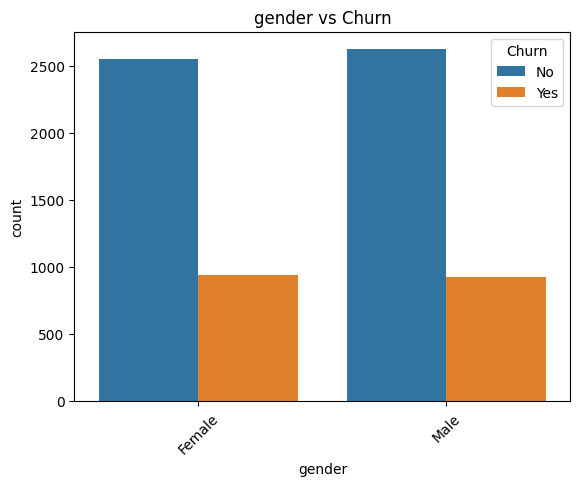

  7%|▋         | 1/15 [00:00<00:08,  1.57it/s]

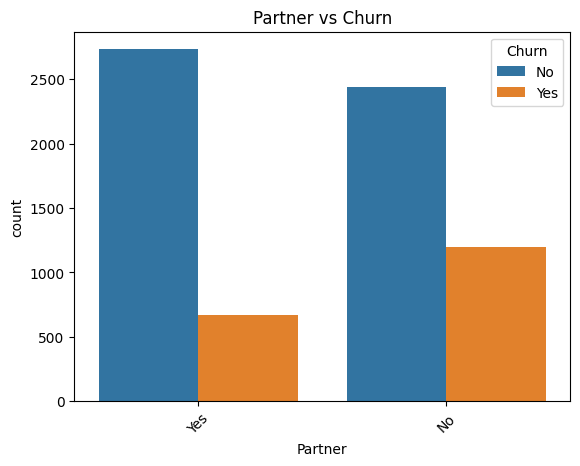

 13%|█▎        | 2/15 [00:01<00:08,  1.48it/s]

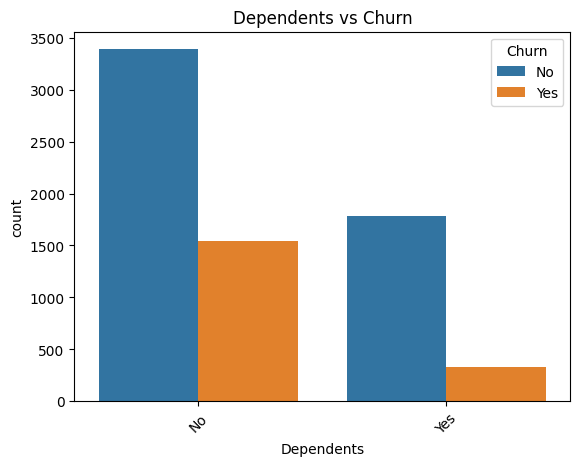

 20%|██        | 3/15 [00:01<00:07,  1.65it/s]

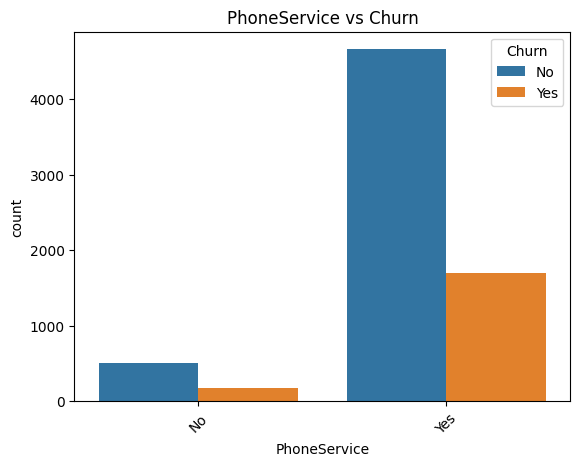

 27%|██▋       | 4/15 [00:02<00:05,  2.12it/s]

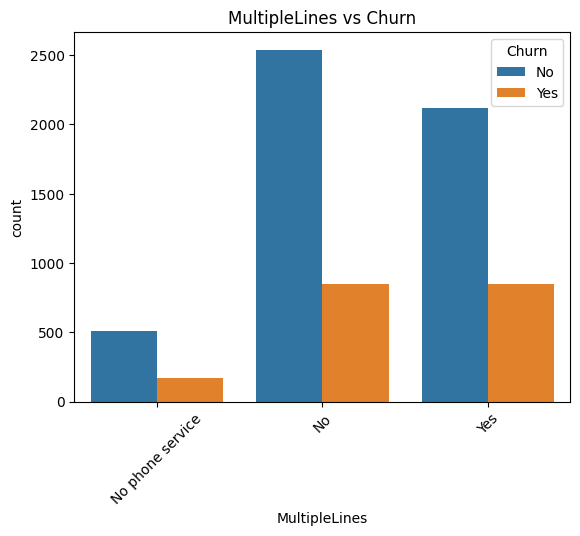

 33%|███▎      | 5/15 [00:02<00:04,  2.36it/s]

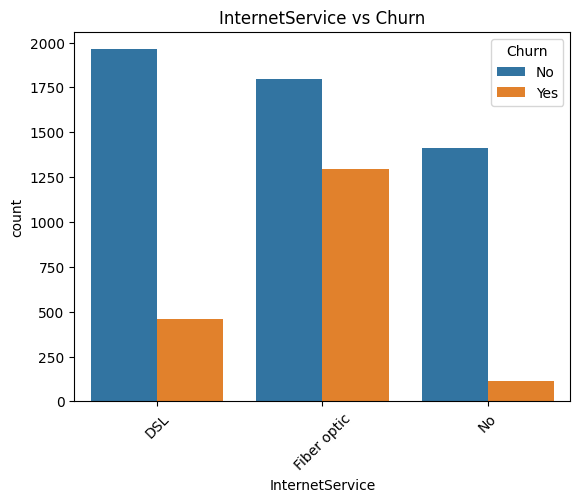

 40%|████      | 6/15 [00:02<00:03,  2.54it/s]

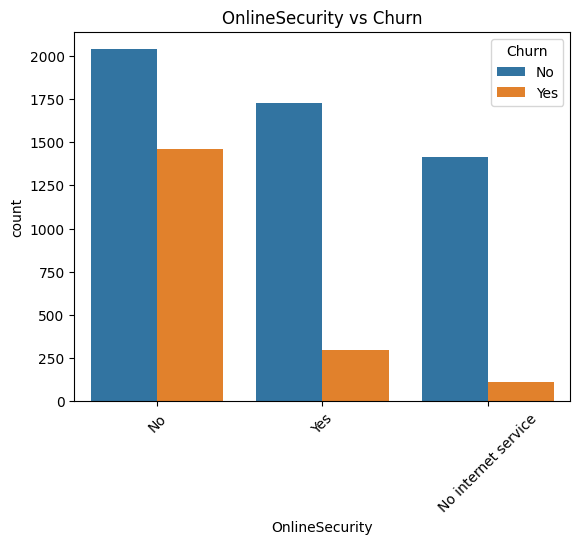

 47%|████▋     | 7/15 [00:03<00:02,  2.71it/s]

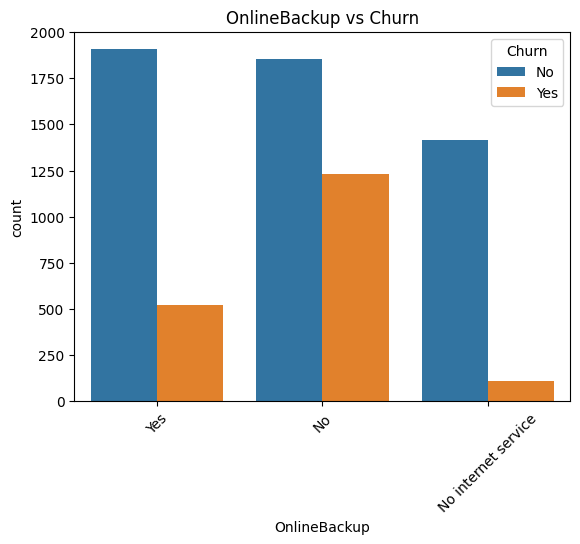

 53%|█████▎    | 8/15 [00:03<00:02,  2.72it/s]

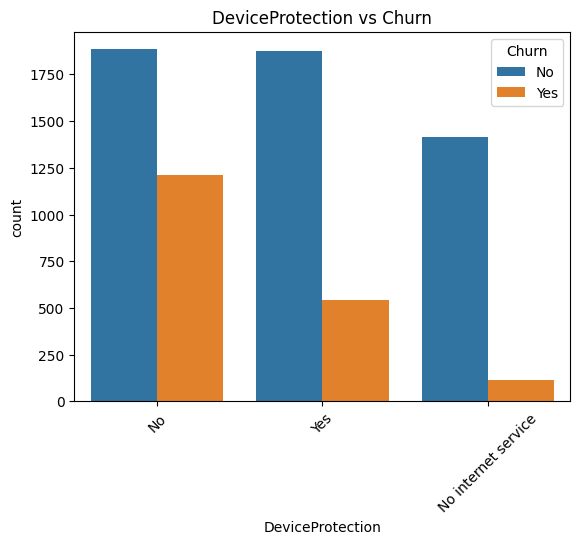

 60%|██████    | 9/15 [00:03<00:02,  2.81it/s]

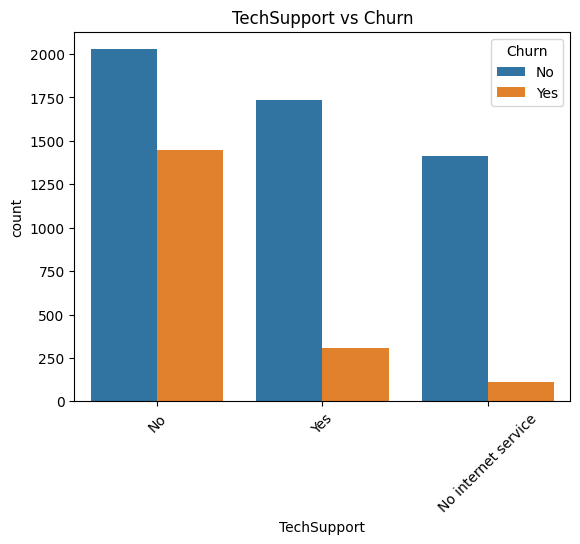

 67%|██████▋   | 10/15 [00:04<00:01,  2.86it/s]

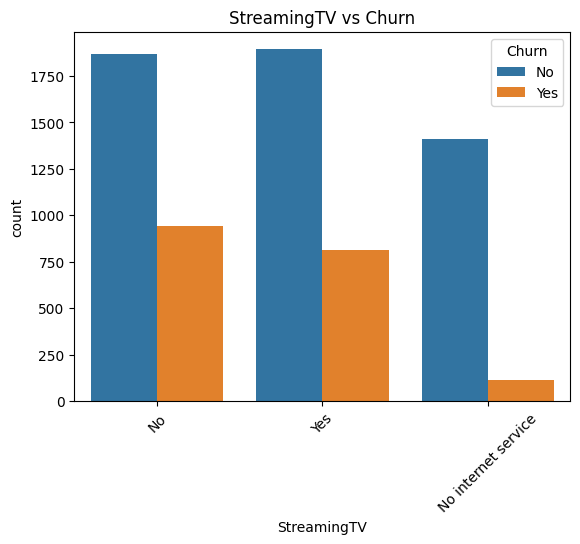

 73%|███████▎  | 11/15 [00:04<00:01,  2.58it/s]

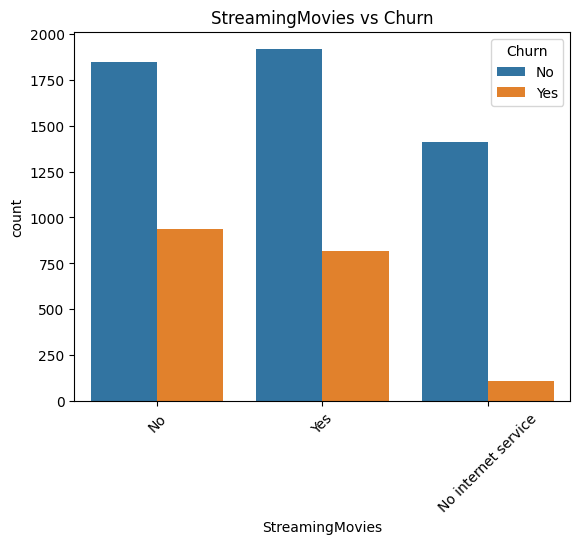

 80%|████████  | 12/15 [00:05<00:01,  2.42it/s]

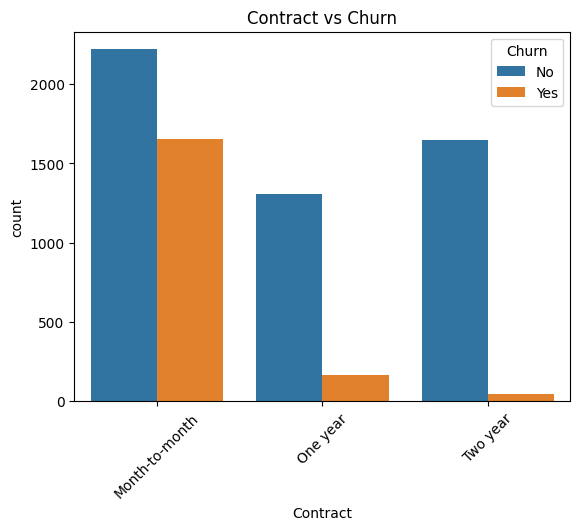

 87%|████████▋ | 13/15 [00:05<00:00,  2.54it/s]

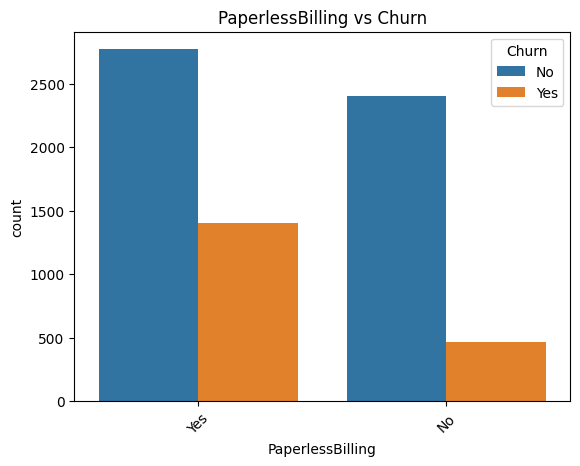

 93%|█████████▎| 14/15 [00:05<00:00,  2.61it/s]

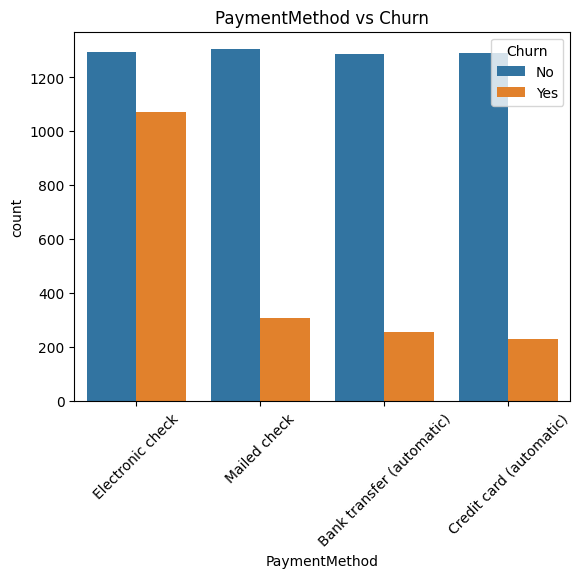

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


In [410]:
# frequency count plots
cat_cols = data.select_dtypes(include=['object']).columns.drop('Churn')
for col in tqdm.tqdm(cat_cols):
    sns.countplot(data=data, x=col, hue='Churn')
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
    plt.show()


In [411]:
for col in cat_cols:
    print(pd.crosstab(data[col], data['Churn'], normalize='index'))

Churn         No       Yes
gender                    
Female  0.730791  0.269209
Male    0.738397  0.261603
Churn          No       Yes
Partner                    
No       0.670420  0.329580
Yes      0.803351  0.196649
Churn             No       Yes
Dependents                    
No          0.687209  0.312791
Yes         0.845498  0.154502
Churn               No       Yes
PhoneService                    
No            0.750733  0.249267
Yes           0.732904  0.267096
Churn                   No       Yes
MultipleLines                       
No                0.749558  0.250442
No phone service  0.750733  0.249267
Yes               0.713901  0.286099
Churn                  No       Yes
InternetService                    
DSL              0.810409  0.189591
Fiber optic      0.581072  0.418928
No               0.925950  0.074050
Churn                      No       Yes
OnlineSecurity                         
No                   0.582333  0.417667
No internet service  0.925950  0.074050

In [412]:
for col in cat_cols:
    table = pd.crosstab(data[col], data['Churn'])
    chi2, p, _, _ = chi2_contingency(table)
    significance = "Significant" if p < 0.05 else "Not Significant"
    print(f"{col}: p-value = {p:.4f} - {significance}")

gender: p-value = 0.4866 - Not Significant
Partner: p-value = 0.0000 - Significant
Dependents: p-value = 0.0000 - Significant
PhoneService: p-value = 0.3388 - Not Significant
MultipleLines: p-value = 0.0035 - Significant
InternetService: p-value = 0.0000 - Significant
OnlineSecurity: p-value = 0.0000 - Significant
OnlineBackup: p-value = 0.0000 - Significant
DeviceProtection: p-value = 0.0000 - Significant
TechSupport: p-value = 0.0000 - Significant
StreamingTV: p-value = 0.0000 - Significant
StreamingMovies: p-value = 0.0000 - Significant
Contract: p-value = 0.0000 - Significant
PaperlessBilling: p-value = 0.0000 - Significant
PaymentMethod: p-value = 0.0000 - Significant


- We then focus on our numeric variables to see how they compare between churners and non churners. We use box plots to gain a better idea of this.

- We also create histograms to see the distribution shape to get a better idea of if these variables are normally distributed or skewed.

  0%|          | 0/3 [00:00<?, ?it/s]

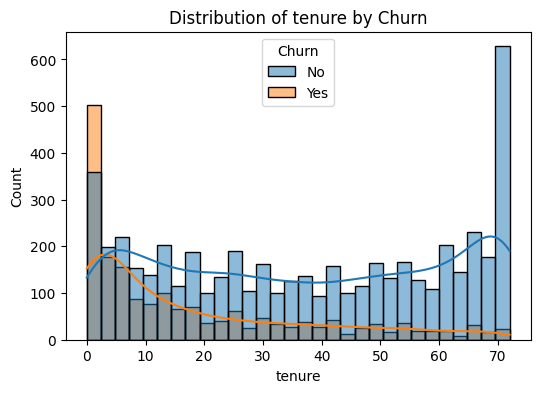

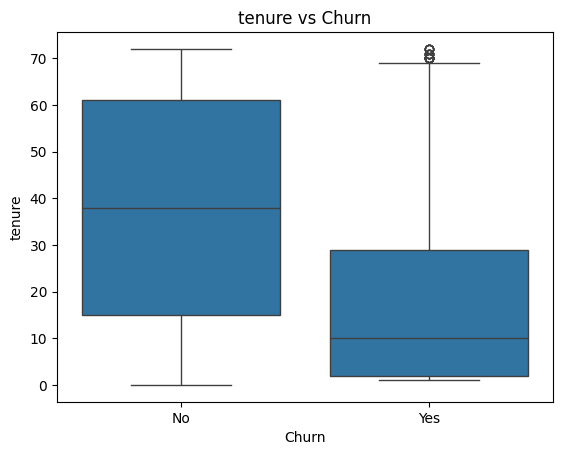

 33%|███▎      | 1/3 [00:01<00:03,  1.65s/it]

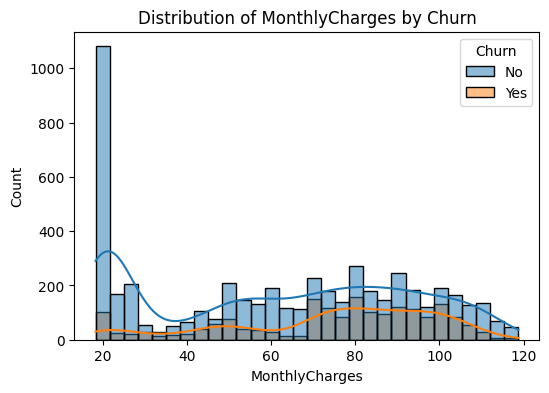

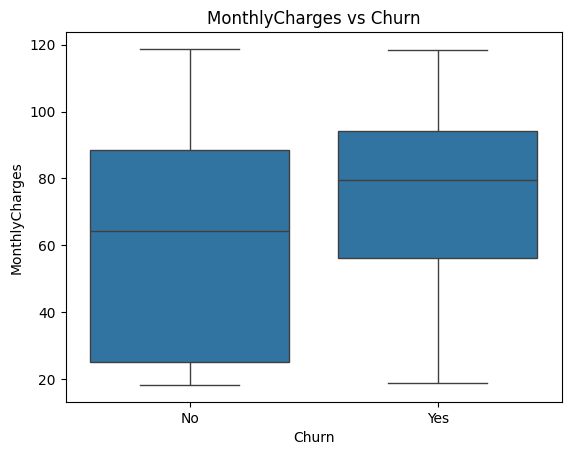

 67%|██████▋   | 2/3 [00:02<00:00,  1.04it/s]

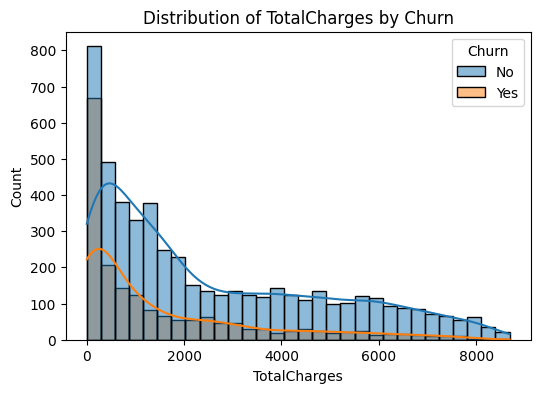

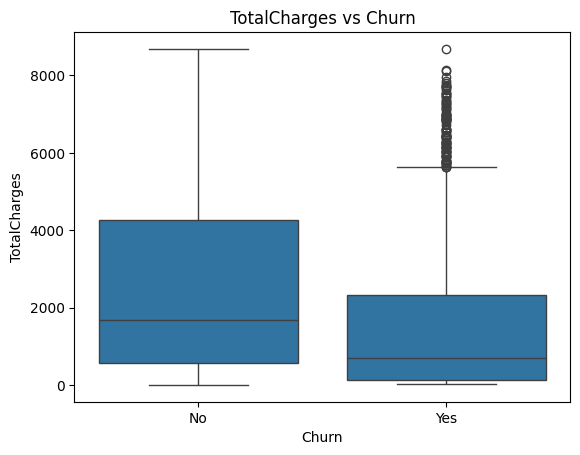

100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


In [413]:
# numeric variables shape check and box plot
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in tqdm.tqdm(num_cols):
    plt.figure(figsize=(6,4))
    sns.histplot(data, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f"Distribution of {col} by Churn")
    plt.show()

    sns.boxplot(data=data, x='Churn', y=col)
    plt.title(f"{col} vs Churn")
    plt.show()

We then create a heat map to check the correlation between the numeric variables. This helps us detect collinearity. If for eg: TotalCharges is highly correlated with MonthlyCharges × tenure it can affect model stability. This allows us to identify if there are any numerical features that can be dropped to make our modeling simpler.

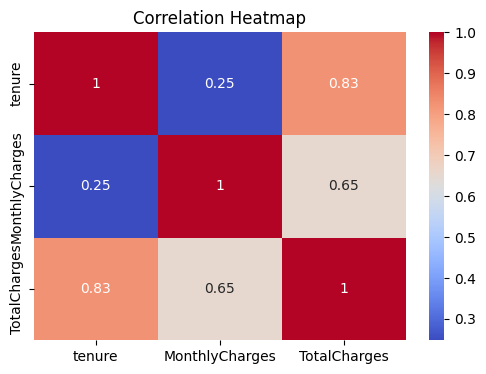

In [414]:
# heatmap
plt.figure(figsize=(6,4))
sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


From all the analysis above we were able to gather data points around our variables such as:

- Through the plots for frequency count we were able to see that month to month contract typically churn more than the other cases and so on.

- Partner has its p-value < 0.01 making it statistically significant with churn while gender is p value is 0.48 making it greater than 0.05 and showing that it likely is independent of churn.

- Through the histogram for our numeric variables we are able to see how churners are mostly in low tenure range and more. Additionally through the heat map we also notice how Total Charges is strongly correlated with tenure and Monthly charges while tenure and MonthlyCharges are fairly independent.

Please note that the above are few of the multiple different data points that hav been collected in doing this assignment

Before checking for our assumptions we needed to feature engineer our dataset:

- From our above analysis many features such as PhoneService or Partner and so on are binary categorical variables with the levels as: Yes and No. The models we plan on generating require numeric inputs. For this reason we will go ahead and Map Yes -> 1 and No -> 0. This converts these variables into a form that models interpret as binary indicators

- Some variables have more than two categories such as Payment method or Contract. In such cases we perform on hot encoding that creates dummy variables for each category. Now by default these dummy variables return True/False values therefore we cast these to integers to ensure they have numeric inputs.

In [415]:
# select the binary columns
binary_cols = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']

for col in binary_cols:
    data[col] = data[col].map({'Yes':1,'No':0})

# sanity check to ensure that mapping worked
print(data[binary_cols].head())


   Partner  Dependents  PhoneService  PaperlessBilling  Churn
0        1           0             0                 1      0
1        0           0             1                 0      0
2        0           0             1                 1      1
3        0           0             0                 0      0
4        0           0             1                 1      1


In [416]:
data.shape

(7043, 20)

In [417]:
# columns with >2 options needs one hot encoding
cat_cols = data.select_dtypes(include=['object']).columns

data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

# to change it from True/False to 1/0
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

In [418]:
data.shape

(7043, 31)

In [419]:
data.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,34,1,0,56.95,1889.50,0,1,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,2,1,1,53.85,108.15,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,45,0,0,42.30,1840.75,0,1,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,2,1,1,70.70,151.65,1,0,...,0,0,0,0,0,0,0,0,1,0


Assumptions for Linear Regression:

In [420]:
# set the data for creation of model. X -> predictors, Y-> target
X = data.drop(columns=['Churn'])
y = data['Churn']

In [421]:
# fit OLS model
X_const = sm.add_constant(X)
lin_model = sm.OLS(y, X_const).fit()

# regression summary
lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sat, 13 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:13:56   Log-Likelihood:                -3058.7
No. Observations:                7043   AIC:                             6165.
Df Residuals:                    7019   BIC:                             6330.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.2738      0.103      2.664      0.008       0.072       0.475
SeniorCitizen                             0.0442      0.013      3.403      0.001       0.019       0.070
Partner                                  -0.0012      0.011     -0.113      0.910      -0.022       0.020
Dependents                               -0.0209      0.011     -1.826      0.068      -0.043       0.002
tenure                                   -0.0019      0.000     -3.799      0.000      -0.003      -0.001
PhoneService                              0.1347      0.095      1.417      0.156      -0.052       0.321
PaperlessBilling                          0.0449      0.010      4.502      0.000       0.025       0.064
MonthlyCharges                           -0.0013      0.004     -0.309      0.757      -0.010       0.007
TotalCharges                           -4.44e-05   6.46e-06     -6.870      0.000   -5.71e-05   -3.17e-05
gender_Male                              -0.0033      0.009     -0.369      0.712      -0.021       0.014
MultipleLines_No phone service            0.1391      0.014      9.655      0.000       0.111       0.167
MultipleLines_Yes                         0.0581      0.024      2.387      0.017       0.010       0.106
InternetService_Fiber optic               0.2110      0.109      1.929      0.054      -0.003       0.425
InternetService_No                       -0.0257      0.016     -1.631      0.103      -0.057       0.005
OnlineSecurity_No internet service       -0.0257      0.016     -1.631      0.103      -0.057       0.005
OnlineSecurity_Yes                       -0.0427      0.025     -1.720      0.085      -0.091       0.006
OnlineBackup_No internet service         -0.0257      0.016     -1.631      0.103      -0.057       0.005
OnlineBackup_Yes                         -0.0118      0.024     -0.483      0.629      -0.060       0.036
DeviceProtection_No internet service     -0.0257      0.016     -1.631      0.103      -0.057       0.005
DeviceProtection_Yes                      0.0043      0.025      0.174      0.862      -0.044       0.053
TechSupport_No internet service          -0.0257      0.016     -1.631      0.103      -0.057       0.005
TechSupport_Yes                          -0.0438      0.025     -1.754      0.079      -0.093       0.005
StreamingTV_No internet service          -0.0257      0.016     -1.631      0.103      -0.057       0.005
StreamingTV_Yes                           0.0635      0.045      1.412      0.158      -0.025       0.152
StreamingMovies_No internet service      -0.0257      0.016     -1.631      0.103      -0.057       0.005
StreamingMovies_Yes                       0.0664      0.045      1.478      0.139      -0.022       0.155
Contract_

From the initial regression summary we can analyse that:

- The R square value is 0.284 which indicates only 28.4% of churn variability is explained. This shows it is a poor fit for the linear regression model.

- Many predictors are insignifanct since p>0.05

This analysis aligns with the EDA we performed above as well


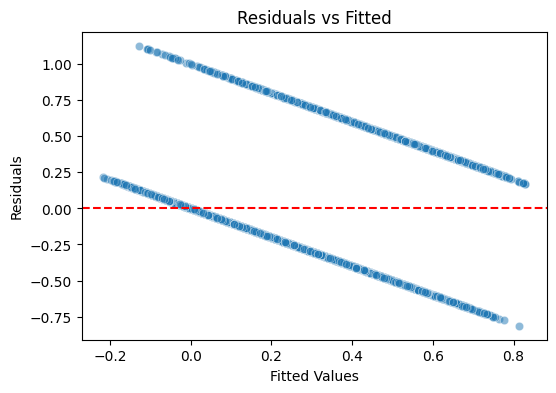

In [422]:
# plot residual vs fitted values to check on assumptions of linearity & homoscedasticity
fitted = lin_model.fittedvalues
resid = lin_model.resid

plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

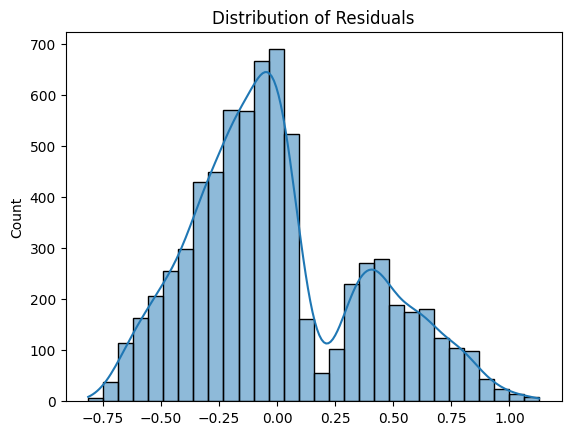

In [423]:
# plot histogram
sns.histplot(resid, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.show()

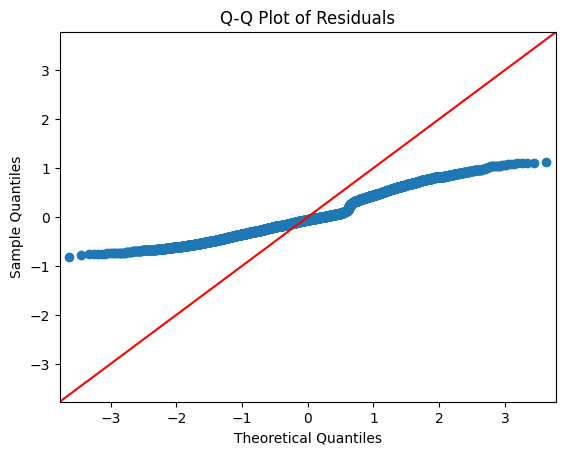

In [424]:
# produce qq plot
sm.qqplot(resid, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [425]:
# get VIF to detect multicollinearity
vif = pd.DataFrame()
vif['feature'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,SeniorCitizen,1.153365
2,Partner,1.462701
3,Dependents,1.384430
4,tenure,7.527280
5,PhoneService,inf
6,PaperlessBilling,1.209020
7,MonthlyCharges,865.062147
8,TotalCharges,10.793729
9,gender_Male,1.002137


From our plots generated above we learn that:

- The scatterplot generated of residuals vs fitted values shows us a clear pattern rather than a random cloud. Additionally the residuals also fan out at different levels of the fitted values thereby indicating  heteroscedasticity which violates one of linear regression assumptions where residuals are expected to have equal variance across the range of predicted values

- From the histogram of the residual the distribution is bi model and is not bell shaped and symmetric.

- The QQ plots show substantial deviation from the reference line thereby confirming that the residuals are not normally distributed.

- By calculating the VIF we see that it indicates severe multicollinearity among predictors which several dummy variables having infinite VIF values and variables like MonthlyCharges (VIF = 865) and InternetService_Fiber optic (VIF = 148).

Overall from our analysis the linear regression model violates multiple assumptions.

Assumptions for Logistic Regression

In [426]:
# set the data for creation of model. X_log -> predictors, Y_log -> target
X_log = data.drop(columns=['Churn'])
y_log = data['Churn']

In [427]:
# size of data
data.shape

(7043, 31)

In [428]:
# check binary target:
assert set(data['Churn'].unique()).issubset({0,1}), "Churn is not binary!"

In [429]:
# run model
X_log_const = sm.add_constant(X_log)
log_model = sm.Logit(y_log, X_log_const).fit()

# regression summary
log_model.summary()

Optimization terminated successfully.
         Current function value: 0.413764
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7043
Model:                          Logit   Df Residuals:                     7019
Method:                           MLE   Df Model:                           23
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2849
Time:                        18:13:57   Log-Likelihood:                -2914.1
converged:                       True   LL-Null:                       -4075.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                     0.8373        nan        nan        nan         nan         nan
SeniorCitizen                             0.2156      0.081      2.653      0.008       0.056       0.375
Partner                                  -0.0019      0.077     -0.025      0.980      -0.153       0.150
Dependents                               -0.1518      0.090     -1.693      0.091      -0.328       0.024
tenure                                   -0.0603      0.006     -9.637      0.000      -0.073      -0.048
PhoneService                              0.5076        nan        nan        nan         nan         nan
PaperlessBilling                          0.3421      0.075      4.588      0.000       0.196       0.488
MonthlyCharges                           -0.0405      0.017     -2.401      0.016      -0.074      -0.007
TotalCharges                              0.0003   7.07e-05      4.642      0.000       0.000       0.000
gender_Male                              -0.0219      0.065     -0.338      0.735      -0.149       0.105
MultipleLines_No phone service            0.3297   2.75e+06    1.2e-07      1.000    -5.4e+06     5.4e+06
MultipleLines_Yes                         0.4472      0.113      3.974      0.000       0.227       0.668
InternetService_Fiber optic               1.7524      0.405      4.322      0.000       0.958       2.547
InternetService_No                       -0.2562        nan        nan        nan         nan         nan
OnlineSecurity_No internet service       -0.2562        nan        nan        nan         nan         nan
OnlineSecurity_Yes                       -0.2055      0.115     -1.794      0.073      -0.430       0.019
OnlineBackup_No internet service         -0.2562        nan        nan        nan         nan         nan
OnlineBackup_Yes                          0.0255      0.109      0.234      0.815      -0.188       0.239
DeviceProtection_No internet service     -0.2562        nan        nan        nan         nan         nan
DeviceProtection_Yes                      0.1474      0.113      1.303      0.193      -0.074       0.369
TechSupport_No internet service          -0.2562   5.14e+14  -4.99e-16      1.000   -1.01e+15    1.01e+15
TechSupport_Yes                          -0.1795      0.094     -1.902      0.057      -0.365       0.005
StreamingTV_No internet service          -0.2562   5.14e+14  -4.99e-16      1.000   -1.01e+15    1.01e+15
StreamingTV_Yes                           0.5911      0.179      3.302      0.001       0.240       0.942
StreamingMovies_No internet service      -0.2562        nan        nan        nan         nan         nan
StreamingMovies_Yes                       0.6025      0.158      3.807      0.000       0.292       0.913
Contract_One year                        -0.6652      0.108     -6.187      0.000      -0.876      -0.454
Contract_Two year                        -1.3803      0.175  

In [430]:
# get VIF
vif = pd.DataFrame()
vif['feature'] = X_log_const.columns
vif['VIF'] = [variance_inflation_factor(X_log_const.values, i) for i in range(X_log_const.shape[1])]
vif

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,SeniorCitizen,1.153365
2,Partner,1.462701
3,Dependents,1.384430
4,tenure,7.527280
5,PhoneService,inf
6,PaperlessBilling,1.209020
7,MonthlyCharges,865.062147
8,TotalCharges,10.793729
9,gender_Male,1.002137


From our analysis above we notice that for a logistic regression model:

- Our data has 7043 observation which is sufficient

- The target variable i.e. churn is binary (0/1) which satisfies the requirement for logistic regression

- To check on Linearity of log odds we focus only on tenure, MonthlyCharges, TotalCharges. This is because the assumption states that logit (log-odds) of the outcome is linearly related to the continuous independent variables. For binary features linearity of the log-odds is not required. We notice that all the three variables have a p value < 0.05 indicating that they are significant and the assumption holds.

- On calculating the VIF we noticed that many features show high values indicating strong correlation between them (for eg: Monthly Charge = 865, InternetService_Fiber optic = 148) thereby showing multicollinearity.

Therefore it seems that the assumptions of logistic regression are largely met however there is severe multicollinearity that needs to be accounted for and can affect interpretability

In [431]:
# Separate numeric and categorical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop('Churn')
categorical_cols = data.select_dtypes(exclude=[np.number]).columns

# Create GAM terms
terms = None

# Add numeric columns with splines
for i in range(len(numeric_cols)):
    if terms is None:
        terms = s(i)
    else:
        terms += s(i)

# Add categorical columns as factors
for j in range(len(categorical_cols)):
    terms += f(j + len(numeric_cols))  # offset index for X array

# Combine numeric + categorical columns into X
X_gam = pd.concat([data[numeric_cols], data[categorical_cols]], axis=1)
y_gam = data['Churn']

# Fit the GAM
gam = LogisticGAM(terms).fit(X_gam.values, y_gam.values)
gam.summary()


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     57.6148
Link Function:                        LogitLink Log Likelihood:                                 -2828.1922
Number of Samples:                         7043 AIC:                                             5771.6139
                                                AICc:                                            5772.6147
                                                UBRE:                                                2.826
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.306
Feature Function                  Lam

/tmp/ipython-input-204940019.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [432]:
gam.terms

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + intercept

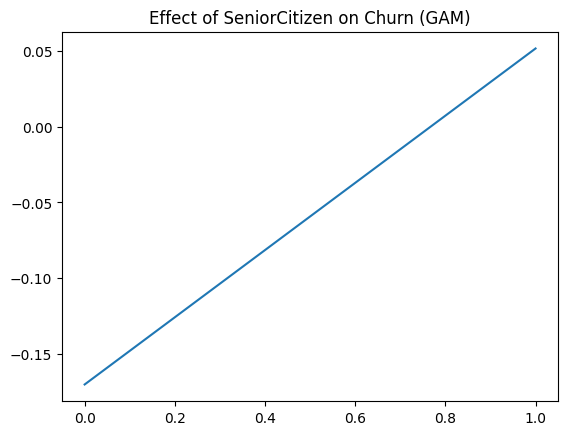

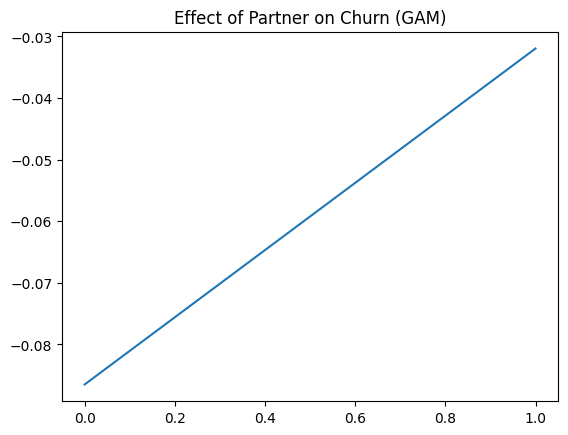

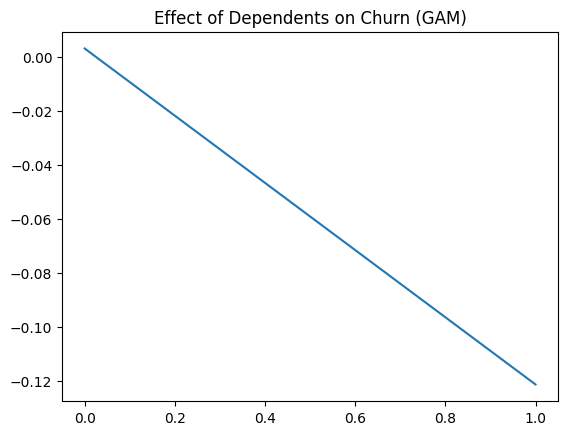

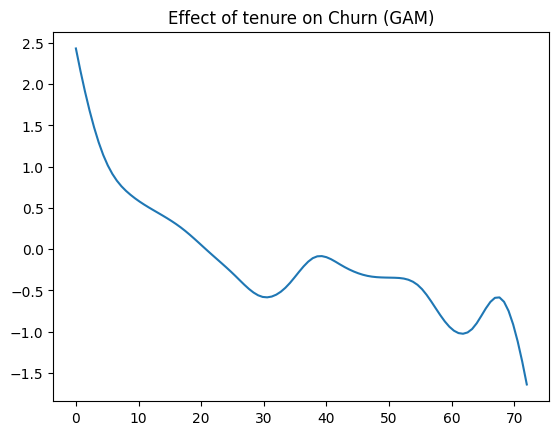

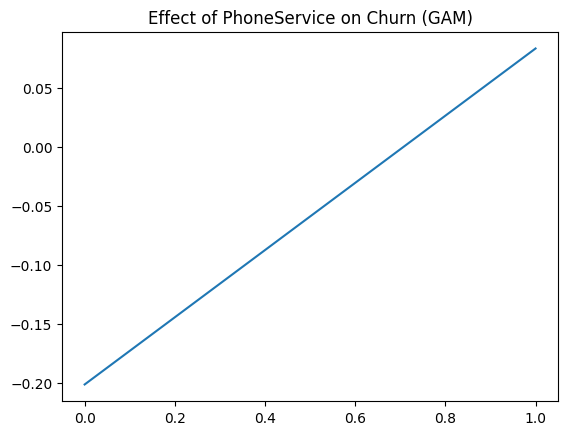

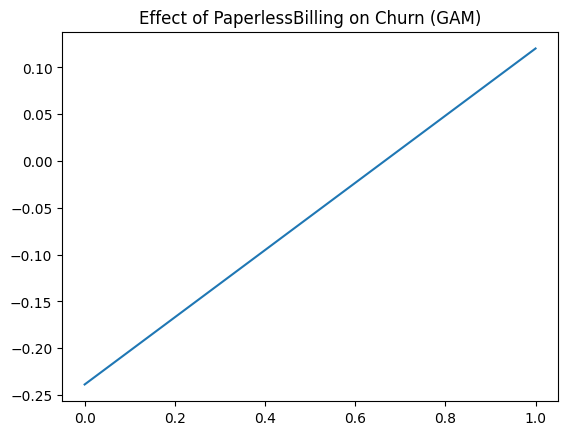

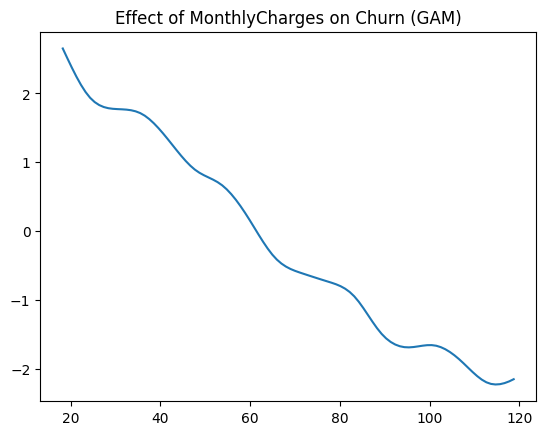

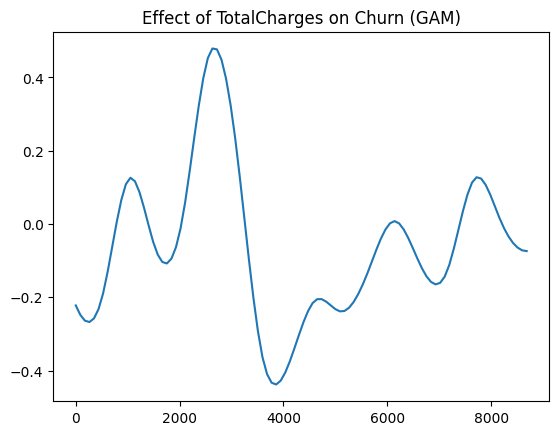

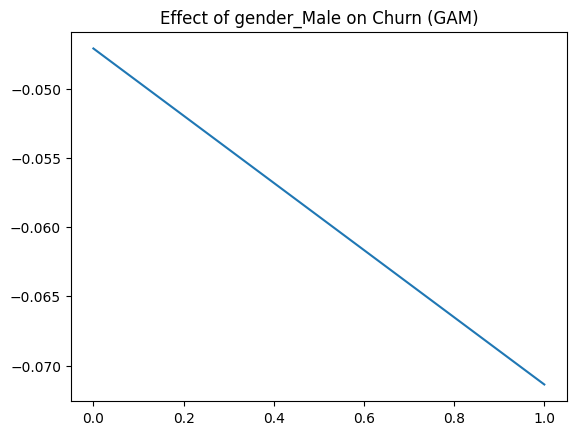

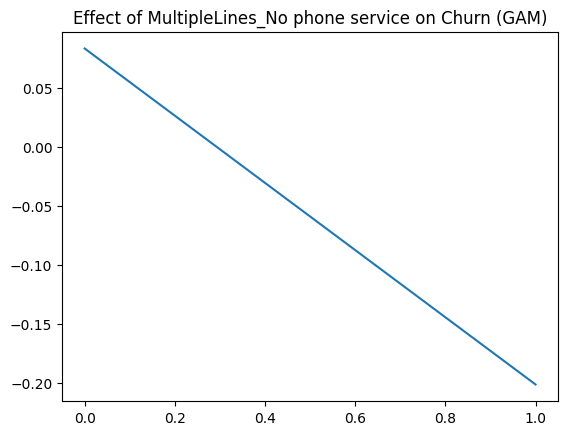

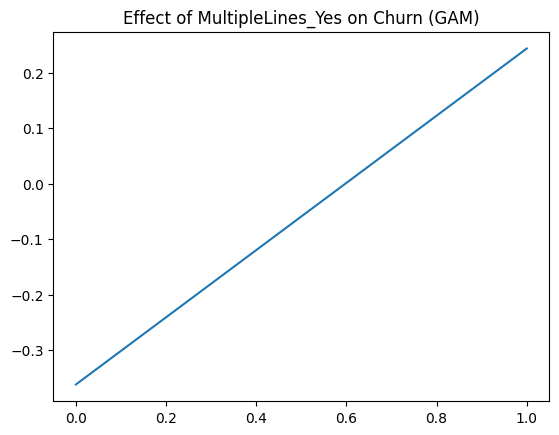

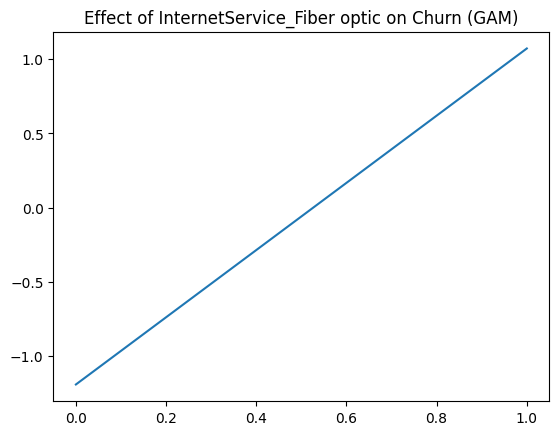

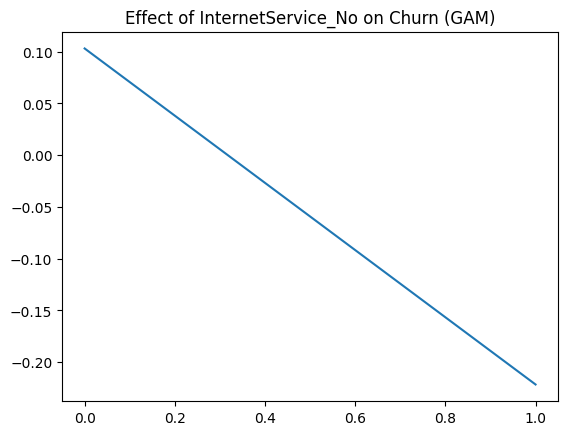

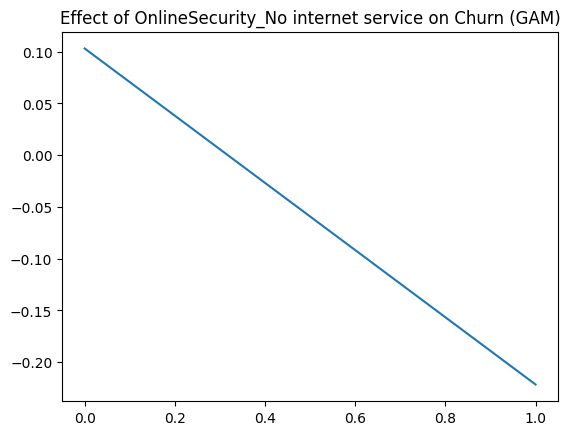

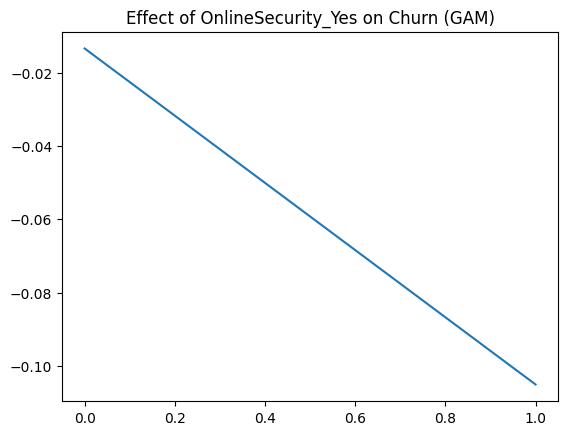

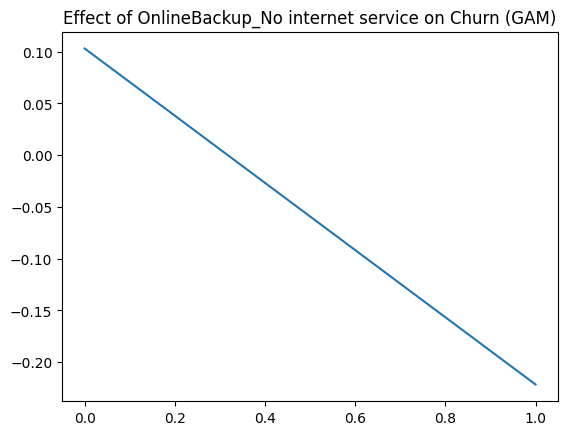

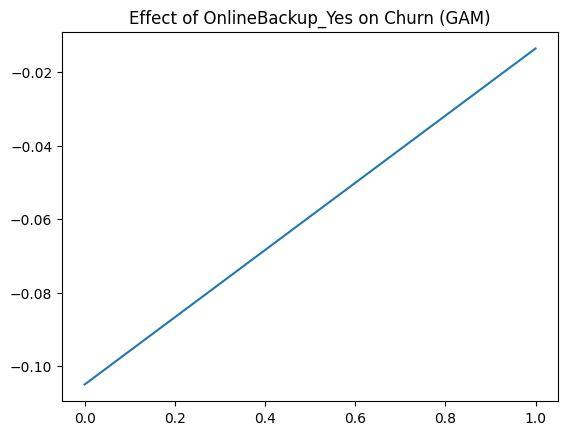

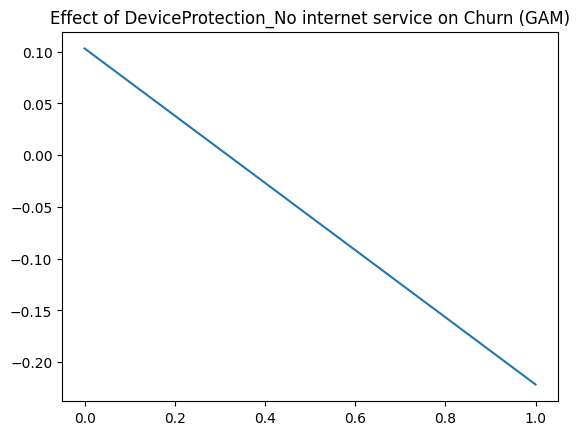

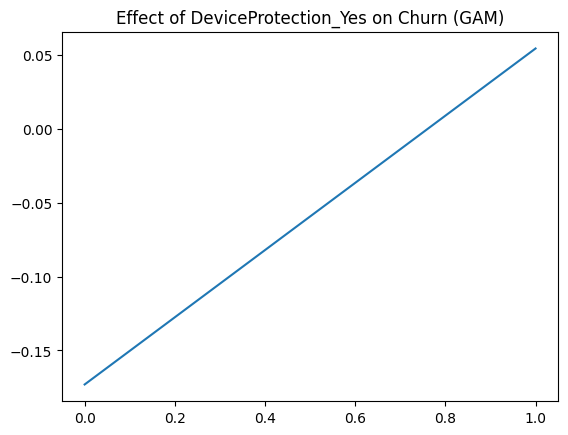

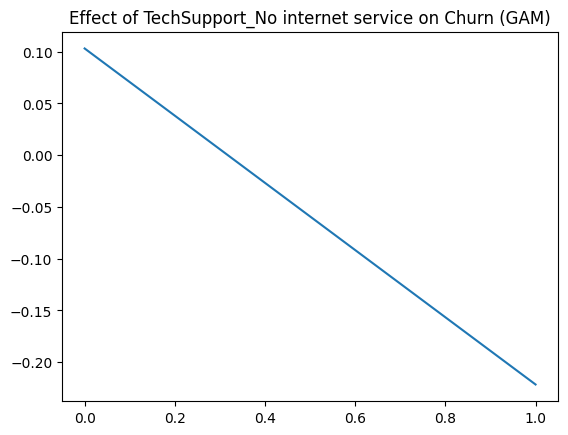

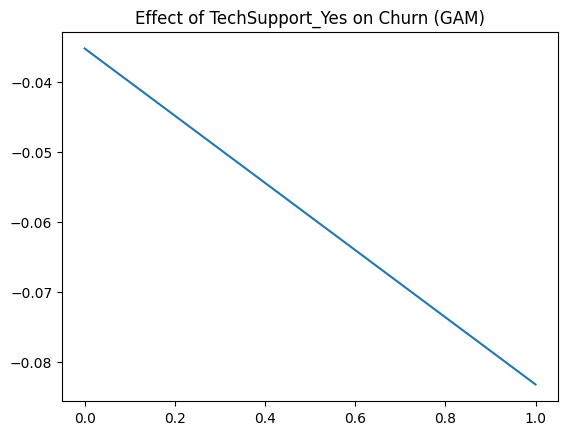

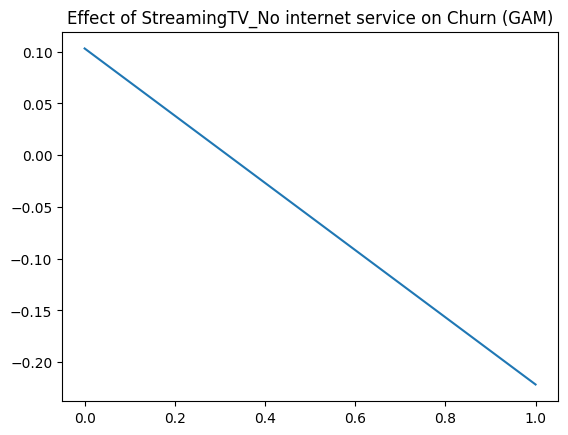

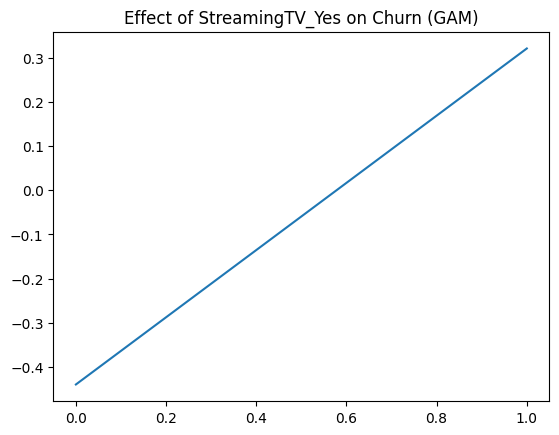

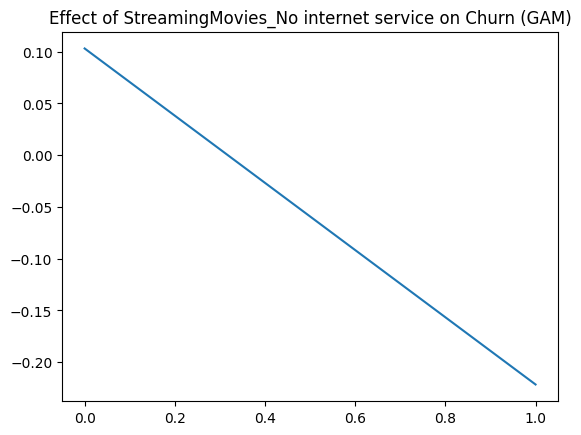

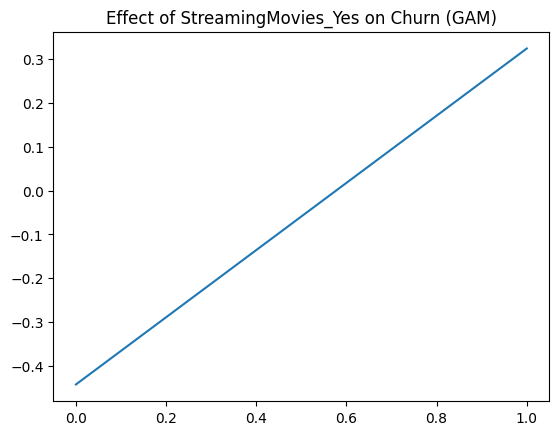

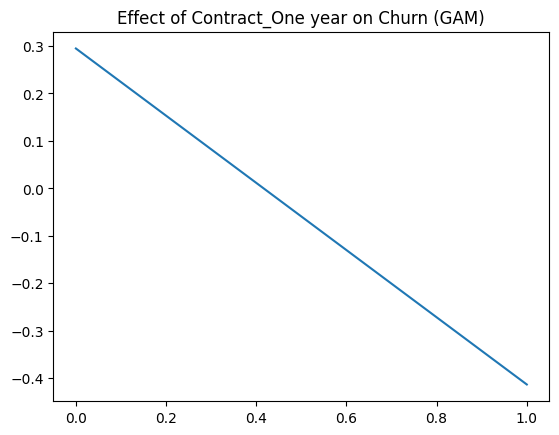

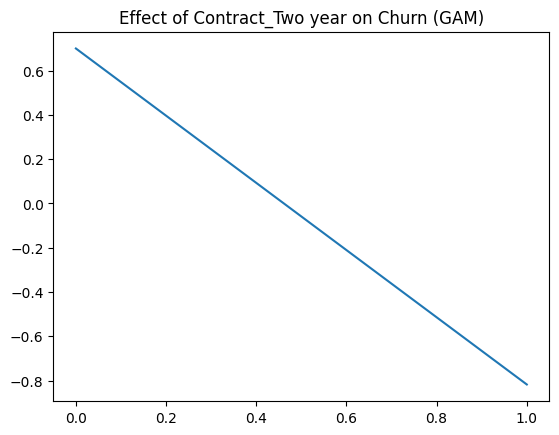

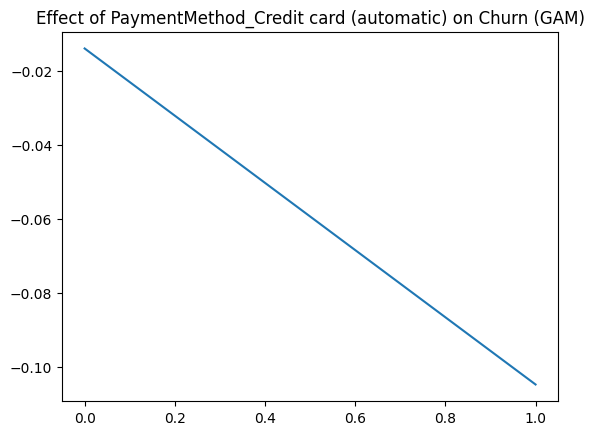

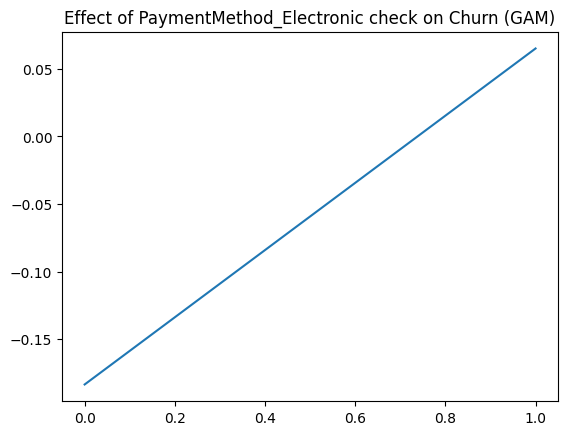

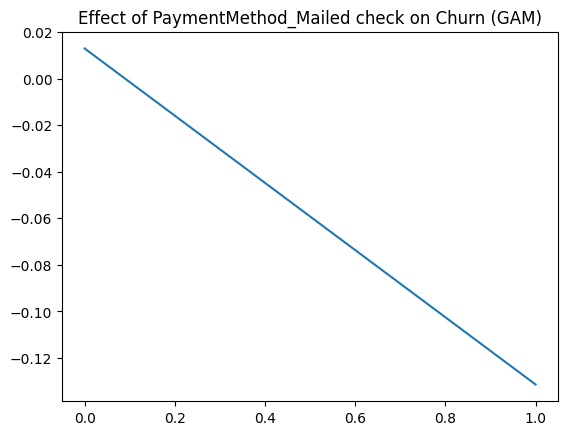

In [433]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.figure()
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Effect of {X_gam.columns[i]} on Churn (GAM)")
    plt.show()

From the above analysis we can say that the GAM assumptions are largely satisfied.

- We are already aware that churn is a binary target

- non linear effects are captured for Tenure, MonthlyCharges, and TotalCharges

Linear Regression Model

From our above analysis to check on assumptions we are aware that some features had a VIF of inifinity which could be problematic. For this we will manually drop those columns

In [434]:
# drop columns based on high multicollinearity seen above
drop_cols = [
    'PhoneService', 'MultipleLines_No phone service', 'InternetService_No',
    'OnlineSecurity_No internet service', 'OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service', 'StreamingMovies_No internet service'
]

X = data.drop(columns=drop_cols + ['Churn'])
y = data['Churn']

In [435]:
# split data into 3 i.e. train (70%), valid (15%), test(15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(X_train.shape, X_test.shape, X_val.shape)


(4930, 21) (1056, 21) (1057, 21)


In [436]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)
X_val_const = sm.add_constant(X_val)

# fit
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     91.23
Date:                Sat, 13 Sep 2025   Prob (F-statistic):               0.00
Time:                        18:14:23   Log-Likelihood:                -2152.3
No. Observations:                4930   AIC:                             4349.
Df Residuals:                    4908   BIC:                             4492.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [437]:
# predict
y_train_pred = ols_model.predict(X_train_const)
y_test_pred = ols_model.predict(X_test_const)
y_val_pred = ols_model.predict(X_val_const)

# set threshold at 0.5
y_train_pred_bin = (y_train_pred >= 0.5).astype(int)
y_test_pred_bin = (y_test_pred >= 0.5).astype(int)
y_val_pred_bin = (y_val_pred >= 0.5).astype(int)




In [438]:
# model perfromance metrics
print("=== Train Metrics ===")
print("R2:", r2_score(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Accuracy:", accuracy_score(y_train, y_train_pred_bin))
print("F1:", f1_score(y_train, y_train_pred_bin))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))


print("\n=== Test Metrics ===")
print("R2:", r2_score(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("Accuracy:", accuracy_score(y_test, y_test_pred_bin))
print("F1:", f1_score(y_test, y_test_pred_bin))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))


print("\n=== Validation Metrics ===")
print("R2:", r2_score(y_val, y_val_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("Accuracy:", accuracy_score(y_val, y_val_pred_bin)
)
print("F1:", f1_score(y_val, y_val_pred_bin))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))


=== Train Metrics ===
R2: 0.28076669518152686
RMSE: 0.37442606221589364
Accuracy: 0.7989858012170385
F1: 0.5719222462203024
ROC-AUC: 0.8439551154430028

=== Test Metrics ===
R2: 0.264812953129819
RMSE: 0.37848169626239864
Accuracy: 0.7992424242424242
F1: 0.5875486381322957
ROC-AUC: 0.8439551154430028

=== Validation Metrics ===
R2: 0.27257198253237525
RMSE: 0.3767940579942735
Accuracy: 0.7880794701986755
F1: 0.5352697095435685
ROC-AUC: 0.8439551154430028


Co-efficients:

- We have our intercept at 0.1465 which indicates that the baseline probability when all other predictors are zero will be 14.7%

- Positive coefficients indicate an increase in churn probability.  For example: PaymentMethod_Electronic check, PaymentMethod_Electronic check and PaperlessBilling increase churn roughly by 8.4%, 7% and 6% respectively.

- Negative coefficients indicate a decrease in churn probability. For example: Contract_One year and Contract_Two year decrease churn roughly by 13% and 10% respectively.

- We also notice that there are some insignificant predictors with a p value greater than 0.05. These are Partner, gender_Male, DeviceProtection_Yes, StreamingTV_Yes, PaymentMethod_Credit card/mailed check and they show little predictive power after accounting for other variables.

Model Perfromance:

- We notice that across our splits the r square value ranges between 26%-28% which can be seen as moderate performance as churn behavior is relatively noisy.

- On average our RMSE was 0.37 i.e. our predictions deviated roughly 37 percentage points from actual outcome. This is not ideal for precise probability predictions

- We notice that accuracy for our model across the three sets of data is roughy 79% however we must note that the data is highly imbalanced so this can be misleading. This is where we check F1 scores that balances out our precision and recall. This indicates the the model struggles to correctly classify churners, even though overall accuracy is high.


Logistic Regression Model

From our above analysis to check on assumptions we are aware that some features had a VIF of inifinity which could be problematic. For this we will manually drop those columns

In [439]:
# drop columns based on high multicollinearity seen above
cols_to_drop = [
    'PhoneService','MultipleLines_No phone service','InternetService_No',
    'OnlineSecurity_No internet service','OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service','StreamingMovies_No internet service',
]

X = data.drop(columns=cols_to_drop + ['Churn'])
y = data['Churn']


In [440]:
# split data into 3 i.e. train (70%), valid (15%), test(15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (4930, 21)
Validation size: (1056, 21)
Test size: (1057, 21)


In [441]:
X_train_const = sm.add_constant(X_train)
X_val_const = sm.add_constant(X_val)
X_test_const = sm.add_constant(X_test)

# fit
logit_model = sm.Logit(y_train, X_train_const)
logit_result = logit_model.fit()
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.418243
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4930
Model:                          Logit   Df Residuals:                     4908
Method:                           MLE   Df Model:                           21
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.2771
Time:                        18:14:24   Log-Likelihood:                -2061.9
converged:                       True   LL-Null:                       -2852.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.3104      

In [442]:
# predict
y_train_prob = logit_result.predict(X_train_const)
y_val_prob = logit_result.predict(X_val_const)
y_test_prob = logit_result.predict(X_test_const)

# set threshold at 0.5
y_train_pred = (y_train_prob >= 0.5).astype(int)
y_val_pred = (y_val_prob >= 0.5).astype(int)
y_test_pred = (y_test_prob >= 0.5).astype(int)

In [443]:
# model performance metrics
print("=== Train Metrics ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\n=== Validation Metrics ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Train Metrics ===
Accuracy: 0.8016227180527383
F1 Score: 0.5827645051194539
ROC-AUC: 0.8439551154430028
Confusion Matrix:
 [[3269  353]
 [ 625  683]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3622
           1       0.66      0.52      0.58      1308

    accuracy                           0.80      4930
   macro avg       0.75      0.71      0.73      4930
weighted avg       0.79      0.80      0.79      4930


=== Validation Metrics ===
Accuracy: 0.7935606060606061
F1 Score: 0.5855513307984791
ROC-AUC: 0.837239966863034
Confusion Matrix:
 [[684  92]
 [126 154]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       776
           1       0.63      0.55      0.59       280

    accuracy                           0.79      1056
   macro avg       0.74      0.72      0.72      1056
weighted avg       0.79      0.79      0.79      1056


=== Test Metrics ===
Accuracy: 0.796

Co-efficients:

- Positive coefficients increases the log odds of churn. For eg: PaperlessBilling and PaymentMethod_Electronic check being 0.47 and 0.42 respectively. One must note that the interpretation in this case is in log odd so we need to exponentiate the coefficients to get the odds ratio i.e. exp(0.4705) is roughly 1.60 and indicates that customers with paperless billing are ~ 1.6× more likely to churn than those without, all else equal.

- Negative coefficients decreases the log odds of churn. For eg: OnlineSecurity_Yes and TechSupport_Yes check being -0.41 and -0.37 respectively. We can follow the same practice as above to calculate the odds ratio.

- We also notice a large number of coefficients with p values less than 0.05 thereby indicating they are strong predictors ( Contract_One year, Contract_Two year and more). Features like DeviceProtection_Yes, StreamingTV_Yes have p values > 0.05 indicating that they are not statistically significant in relation to churn.

Model Perfromance:

- The model saw an overall average of roughly 80% accuracy when run across the three subsets of data. The consistency of accuracy predictions across the data splits indicates stable performance and suggest that the model can generalize well. However during our EDA we did see the dataset being imbalanced in nature during to which focusing solely on accuracy can be misleading.

- To address the class imbalance we try to evaluate the F1 score and notices that across the three sets of data on average our F1 score is roughly 0.58. This indicates that the model struggles to accurately classify churners despite its high overall accuracy.

- When we focus on the precision, recall and confusion matrix in specific we see that our precision is between 0.63-0.66 while recall is lower at 0.49-0.55. This indicates that when the model predicts a customer will churn, it is correct roughly two-thirds of the time however almost half of the actual churners are missed.

GAM

In [444]:
# drop columns to maintain consistency across all the models as above
cols_to_drop = [
    'PhoneService','MultipleLines_No phone service','InternetService_No',
    'OnlineSecurity_No internet service','OnlineBackup_No internet service',
    'DeviceProtection_No internet service', 'TechSupport_No internet service',
    'StreamingTV_No internet service','StreamingMovies_No internet service',
]

X = data.drop(columns=cols_to_drop + ['Churn'])
y = data['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [445]:
num_features = X_train.shape[1]

num_features

21

In [446]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) +
                  s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) +
                  s(19) + s(20)).fit(X_train, y_train)

In [447]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     53.7784
Link Function:                        LogitLink Log Likelihood:                                 -1996.9029
Number of Samples:                         4930 AIC:                                             4101.3626
                                                AICc:                                            4102.6163
                                                UBRE:                                               2.8406
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2966
Feature Function                  Lam

/tmp/ipython-input-3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [449]:
y_train_pred = gam.predict(X_train)
y_val_pred = gam.predict(X_val)
y_test_pred = gam.predict(X_test)

y_train_prob = gam.predict_proba(X_train)
y_val_prob = gam.predict_proba(X_val)
y_test_prob = gam.predict_proba(X_test)

# model performance metrics
print("=== Train Metrics ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("F1 Score:", f1_score(y_train, y_train_pred))
print("ROC-AUC:", roc_auc_score(y_train, y_train_prob))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print("\n=== Validation Metrics ===")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


=== Train Metrics ===
Accuracy: 0.8097363083164301
F1 Score: 0.5925282363162467
ROC-AUC: 0.8528225690811659
Confusion Matrix:
 [[3310  325]
 [ 613  682]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      3635
           1       0.68      0.53      0.59      1295

    accuracy                           0.81      4930
   macro avg       0.76      0.72      0.73      4930
weighted avg       0.80      0.81      0.80      4930


=== Validation Metrics ===
Accuracy: 0.821969696969697
F1 Score: 0.626984126984127
ROC-AUC: 0.8689500841486194
Confusion Matrix:
 [[710  68]
 [120 158]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       778
           1       0.70      0.57      0.63       278

    accuracy                           0.82      1056
   macro avg       0.78      0.74      0.76      1056
weighted avg       0.81      0.82      0.82      1056


=== Test Metrics ===
Accuracy: 0.7918

Coefficients:

- In GAM each feature captures the smoothed potentially non linear effect of that feature on log odds of churn.

- Having a positive value increased the likelihood of churn while a negative value decreases it. Additionally by having p-values < 0.05 (e.g., s(3), s(5), s(6), s(10), s(11), s(12), s(13), s(15)) are strong predictors of churn.

- As seen in our EDA above we are also always of the model successfully capturing non-linear effects for critical features like Tenure, MonthlyCharges, and TotalCharges.

Model Performance

- We notice that the model has a good overall accuracy amongst the split sets ranging from 80%-82%. However we need to remember that our dataset is imbalanced and looking at accuracy independently could be misleading. This is where F1 scores can be seen. These scores balance precision and recall and are more informative. We notices that they range from 0.57 to 0.63 therefore allowing us to conclude that the model is moderately good at identifying churners, but still misses a substantial portion of them.

- When we look at Precision and Recall for this model we see that precision for churners is between 0.67–0.70. This means that when the model predicts churn, it is correct about two-thirds of the time however the recall for churners is around 0.55 which shows that the model only identifies slightly more than half of actual churners.
